# [Exploration 13] 어제 오른 내 주식, 과연 내일은?
## 프로젝트 설명 
---
ARIMA를 이용해 시계열 데이터 중 주식 데이터를 예측해본다.


## 프로젝트 정리     
---        
1. 데이터 준비
2. 데이터 전처리
3. 시계열 데이터 안정성 분석
4. 데이터셋 생성
5. 적정 ARIMA 모수 찾기
6. ARIMA 모델 훈련과 테스트 
7. 다른 주식 종목 예측해 보기


## 프로젝트 목표
---
- 시계열 데이터의 특성과 분석하는 방법에 대해 이해하기
- 관심있었던 종목들을 예측하면서 재미를 느끼기 


## 01. 데이터 준비
- [Yahoo Finance](https://finance.yahoo.com/)사이트를 이용해 주식 데이터 다운로드합니다.
- 최근 관심있었던 [S&P 500](https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC)로 진행하겠습니다.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [115]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/^GSPC.csv'
df = pd.read_csv(dataset_filepath)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-03-03,3096.459961,3136.719971,2976.629883,3003.370117,3003.370117,6355940000
1,2020-03-04,3045.750000,3130.969971,3034.379883,3130.120117,3130.120117,5035480000
2,2020-03-05,3075.699951,3083.040039,2999.830078,3023.939941,3023.939941,5575550000
3,2020-03-06,2954.199951,2985.929932,2901.540039,2972.370117,2972.370117,6552140000
4,2020-03-09,2863.889893,2863.889893,2734.429932,2746.560059,2746.560059,8423050000


- 여러 데이터가 있지만 종가만 사용하겠습니다.
    * 종가(Close) : 주식 시장이 마감했을 때의 주식 가격

In [116]:
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-03,3096.459961,3136.719971,2976.629883,3003.370117,3003.370117,6355940000
2020-03-04,3045.750000,3130.969971,3034.379883,3130.120117,3130.120117,5035480000
2020-03-05,3075.699951,3083.040039,2999.830078,3023.939941,3023.939941,5575550000
2020-03-06,2954.199951,2985.929932,2901.540039,2972.370117,2972.370117,6552140000
2020-03-09,2863.889893,2863.889893,2734.429932,2746.560059,2746.560059,8423050000


- dataframe 형태의 파일을 Series 형태로 변경하겠습니다.

In [7]:
ts_snp = df['Close']
print(type(ts_snp))
ts_snp.head()

<class 'pandas.core.series.Series'>


Date
2020-03-03    3003.370117
2020-03-04    3130.120117
2020-03-05    3023.939941
2020-03-06    2972.370117
2020-03-09    2746.560059
Name: Close, dtype: float64

## 02. 데이터 전처리
- 결측치 탐색 후 처리(보간)

In [8]:
ts_snp.isnull().sum()

0

In [9]:
ts_snp = ts_snp[ts_snp.isna()]

Series([], Name: Close, dtype: float64)

- 없다고 나오지만 혹시 모르는 결측치를 interpolate 모듈로 처리합니다.

In [10]:
ts_snp.interpolate(method='time')
ts_snp[ts_snp.isna()]

Series([], Name: Close, dtype: float64)

## 03. 시계열 데이터 안정성 분석
- 시각화를 통해 안정성 여부를 확인하고 처리합니다.

### 시계열 데이터와 안정성. 왜 중요할까요? 
먼저, 우리가 예측하고자 하는 시계열 데이터란 time series data입니다.
단어 그대로 **시간의 연속성**을 갖고 있는 데이터를 일컫습니다. 
종속 변수를 예측하기 위한 독립변수를 **시간**으로 사용하는 것입니다.
따라서 시계열 데이터를 분석 및 예측하기 위해서는 몇가지 조건이 필요합니다.
- 시간의 추이와 관계없이 평균, 분산이 불변한다. 
- 시점간의 공분산이 기준 시점과 무관하다.    

이러한 조건을 갖춘 데이터일수록 예측이 맞을 확률이 높아집니다.
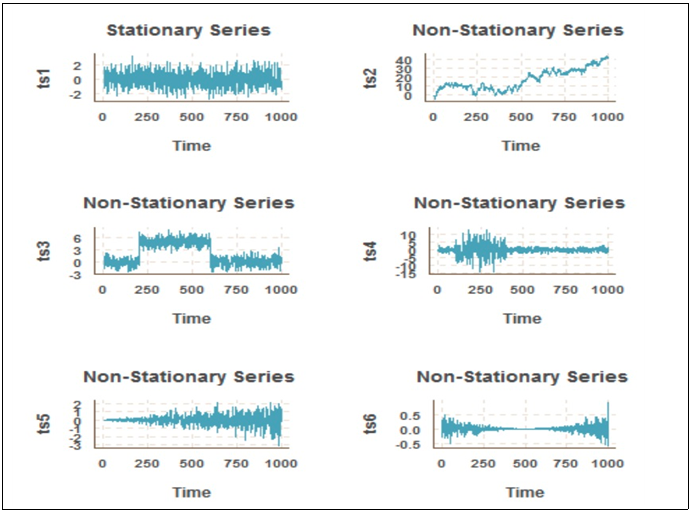
image source : [시계열 데이터 정의와 시계열 자료 분석방법-전통적 방법](https://rosypark.tistory.com/51)   

우리는 데이터가 위 그림처럼 안정적인 형태를 갖고 있는지 확인 후, 오른쪽 그림처럼 불안정적인 데이터라면 왼쪽의 형태로 변환시키는 여러 기법을 사용해 안정성이 있는 데이터로 바꾸어 줄 것입니다.

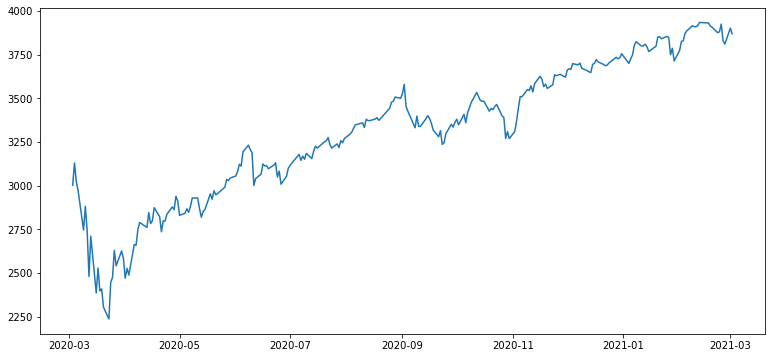

In [11]:
from matplotlib.pylab import rcParams

rcParams['figure.figsize']=13, 6

plt.plot(ts_snp)

**육안으로 보기에는 일정한 패턴을 찾기는 어렵습니다.**
- 일정 시간 내 구간 통계치를 시각화해 뚜렷한 경향성이 있는지 확인하겠습니다.
- window를 이용해서 이동평균, 이동표준편차를 시각화합니다.

In [12]:
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

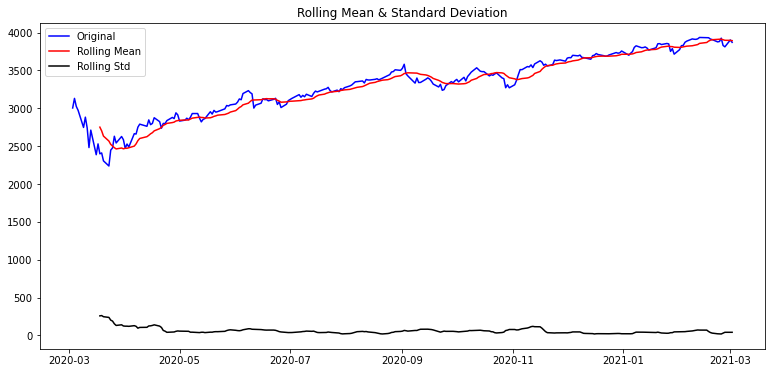

In [13]:
plot_rolling_statistics(ts_snp, window=12)

**평균이 지속적으로 커지는 패턴이 있고, 분산은 평균에 비해서는 안정성을 볼 수 있습니다.**
- 시각화를 통해 확인하는 것보다 통계적 방법이 있습니다.
    - **해당 데이터가 안정적이지 않다**라는 귀무가설을 세우고, 이 귀무가설이 기각되면 대립가설인 **해당 데이터가 안정적이다**를 채택하는 방법입니다.
    - **statsmodels 패키지의 adfuller메소드**를 이용해 **ADF Test** 결과를 확인하겠습니다.
    - 가설 검정의 기본 개념인 **유의확률 p-value**를 통해 확인하겠습니다.
        - p-values는 0.05미만으로 낮게 나올 수록 귀무가설과 관찰된 데이터가 양립한다는 뜻이기 때문에, 대립가설을 채택할 수 있게 됩니다.
        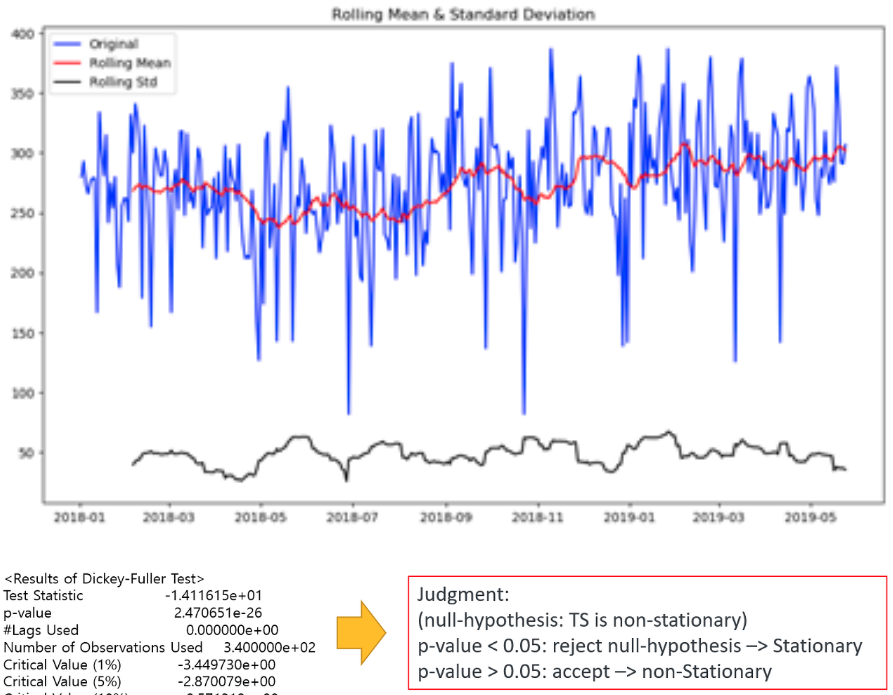
        image source: [시계열 데이터 정의와 시계열 자료 분석방법-전통적 방법](https://rosypark.tistory.com/51)

In [14]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [15]:
augmented_dickey_fuller_test(ts_snp)

Results of Dickey-Fuller Test:
Test Statistic                  -1.690765
p-value                          0.435877
#Lags Used                      10.000000
Number of Observations Used    241.000000
Critical Value (1%)             -3.457779
Critical Value (5%)             -2.873609
Critical Value (10%)            -2.573202
dtype: float64


**p-value가 0.435877으로 나타났습니다. 안정적이지 않은 데이터이므로 안정적인 시계열로 바꾸는 작업이 필요해보입니다.**
- 시각화한 그래프에서 볼 수 있듯이 분산이 점점 증가하고 있습니다.
- 다른 특성도 시계열 분해 시각화를 통해 확인하겠습니다.

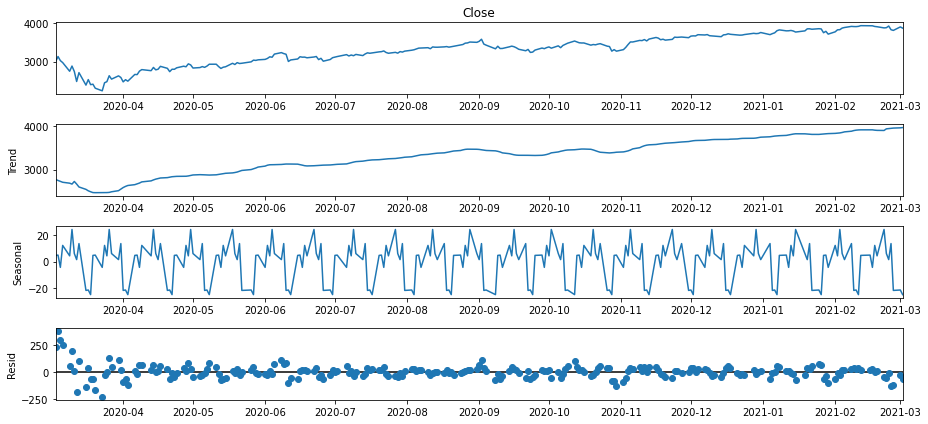

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Close'], model='addictive', two_sided=True, \
                           period=12, extrapolate_trend='freq')
result.plot()
plt.show()

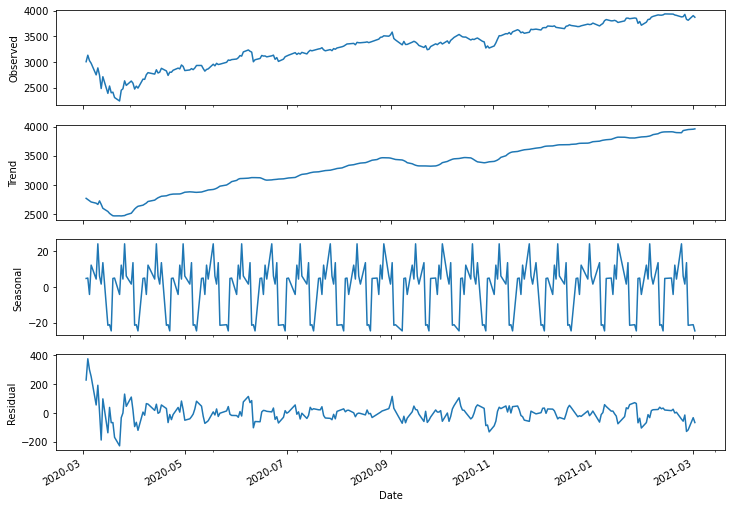

In [17]:
# 그래프를 조금 키워서 확인해볼까요?!

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,9))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

**trend와 seasonnality가 분명하게 확인되는 것을 볼 수 있습니다!**
- 시간에 따른 변화량이 없는 안정적인 데이터가 필요하기 때문에 해당 속성들을 제거하겠습니다. 

- 먼저 분산을 안정적으로 가공하기위해 로그 변환을 취해줍니다.

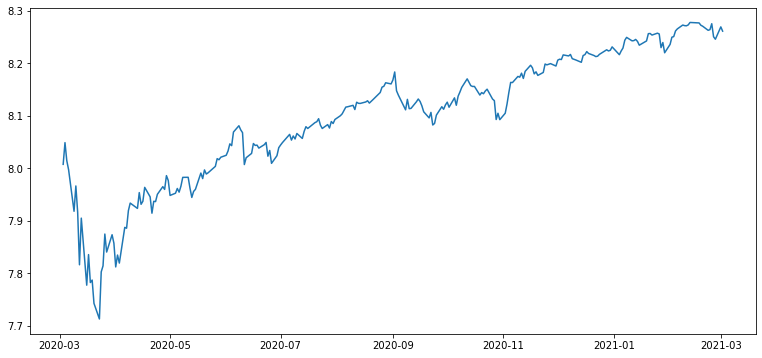

In [18]:
snp_log = np.log(ts_snp)
plt.plot(snp_log)

In [19]:
augmented_dickey_fuller_test(snp_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.054689
p-value                          0.263120
#Lags Used                      10.000000
Number of Observations Used    241.000000
Critical Value (1%)             -3.457779
Critical Value (5%)             -2.873609
Critical Value (10%)            -2.573202
dtype: float64


**로그 변환 이후 p-value가 절반으로 감소했습니다.**  


- 시계열 분해를 통해 확인한 trend(추세)를 상쇄하겠습니다.
- 데이터에서 이동평균을 빼는 방법을 이용합니다.

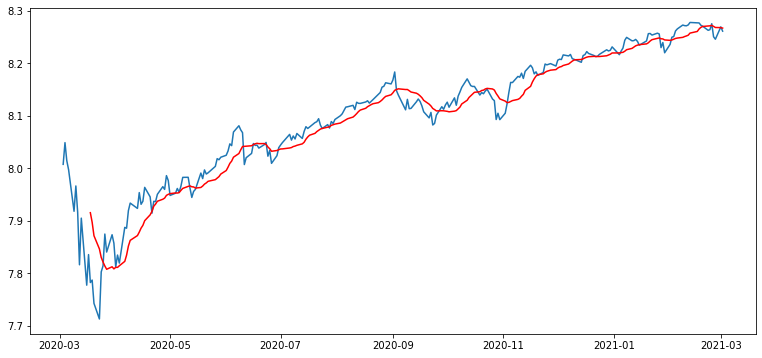

In [20]:
moving_avg = snp_log.rolling(window=12).mean()
plt.plot(snp_log)
plt.plot(moving_avg, color='red')

In [21]:
snp_log_moving_avg = snp_log - moving_avg
snp_log_moving_avg.head(15)

Date
2020-03-03         NaN
2020-03-04         NaN
2020-03-05         NaN
2020-03-06         NaN
2020-03-09         NaN
2020-03-10         NaN
2020-03-11         NaN
2020-03-12         NaN
2020-03-13         NaN
2020-03-16         NaN
2020-03-17         NaN
2020-03-18   -0.133006
2020-03-19   -0.109946
2020-03-20   -0.128771
2020-03-23   -0.133399
Name: Close, dtype: float64

window를 12로 지정했기 때문에 앞의 11개의 데이터는 결측치가 발생합니다.   
해당 데이터를 제거합니다.

In [22]:
snp_log_moving_avg.dropna(inplace=True)
snp_log_moving_avg.head(15)

Date
2020-03-18   -0.133006
2020-03-19   -0.109946
2020-03-20   -0.128771
2020-03-23   -0.133399
2020-03-24   -0.027519
2020-03-25   -0.007393
2020-03-26    0.060780
2020-03-27    0.032823
2020-03-30    0.061023
2020-03-31    0.048861
2020-04-01    0.000819
2020-04-02    0.023467
2020-04-03    0.005125
2020-04-06    0.064732
2020-04-07    0.051206
Name: Close, dtype: float64

- 이제 로그 변환, trend 상쇄를 했습니다.
- 어떻게 변화했을지 확인해봅니다.

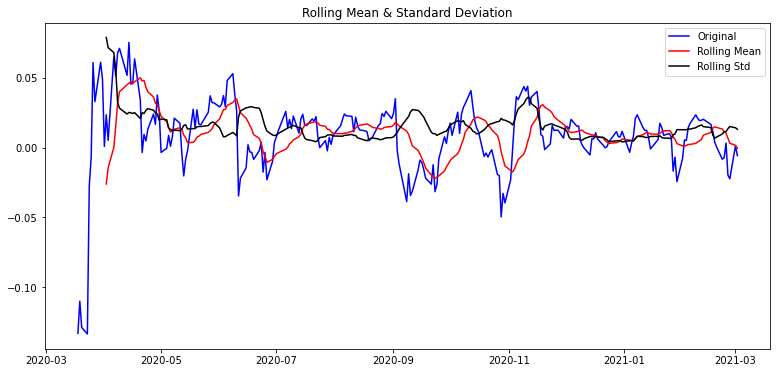

In [24]:
plot_rolling_statistics(snp_log_moving_avg)

In [23]:
augmented_dickey_fuller_test(snp_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                -9.198564e+00
p-value                        2.031111e-15
#Lags Used                     3.000000e+00
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


**p-value가 2.031111e-15로 확실히 더 낮아졌습니다.**

- 차분을 이용해 seasonality(계절성)을 상쇄하겠습니다.
- 시계열 데이터를 한 스텝 이동(shift)한 후에 원 데이터에서 빼주는 방법입니다.
- 현재 스텝 값 - 직전 스텝 값 = 스텝에서 발생한 변화량 

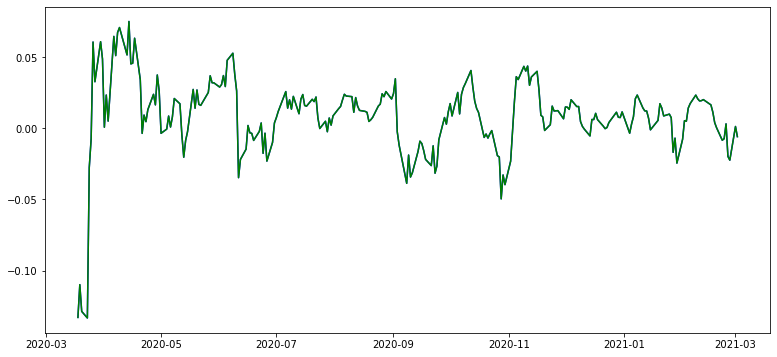

In [25]:
snp_log_shift = snp_log_moving_avg

plt.plot(snp_log_moving_avg, color='blue')
plt.plot(snp_log_shift, color='green')

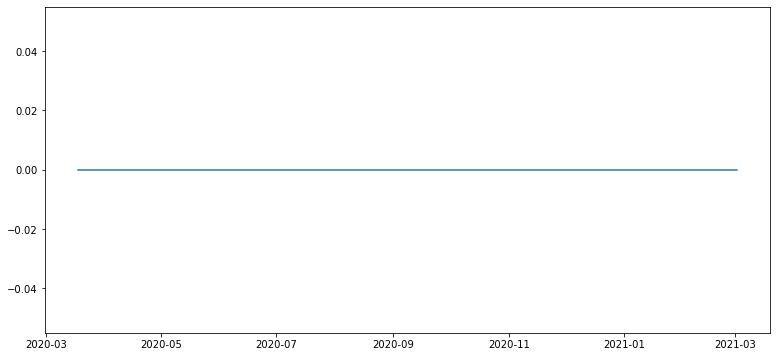

In [26]:
snp_log_moving_avg_diff = snp_log_moving_avg - snp_log_shift
snp_log_moving_avg_diff.dropna(inplace=True)  # 발생한 결측치 제거
plt.plot(snp_log_moving_avg_diff)

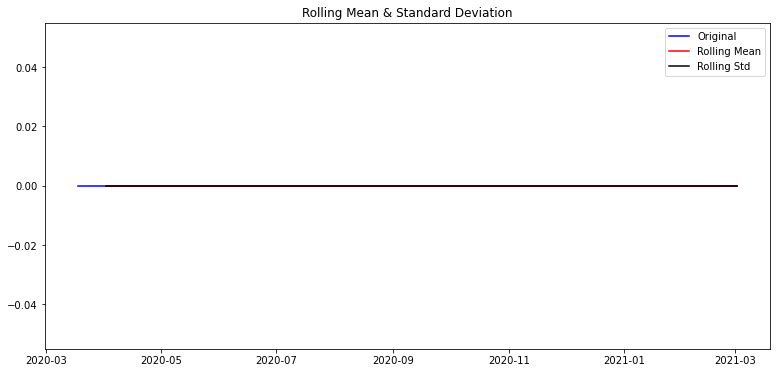

In [27]:
plot_rolling_statistics(snp_log_moving_avg_diff, window=12)

In [28]:
augmented_dickey_fuller_test(snp_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                        NaN
p-value                               NaN
#Lags Used                       0.000000
Number of Observations Used    240.000000
Critical Value (1%)             -3.457894
Critical Value (5%)             -2.873659
Critical Value (10%)            -2.573229
dtype: float64


/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


**p-value가 너무 작아서 NaN값이 됐습니다.**
- 사실 지금까지 진행한 tred, seasonality 상쇄 등의 작업은 메소드로 쉽게 할 수 있습니다. 
- statsmodels안의 seasonal_decompose 메소드를 이용해 다시 해보겠습니다.
- 로그변환 후의 데이터를 이용합니다.

In [29]:
snp_log[snp_log.isna()]

Series([], Name: Close, dtype: float64)

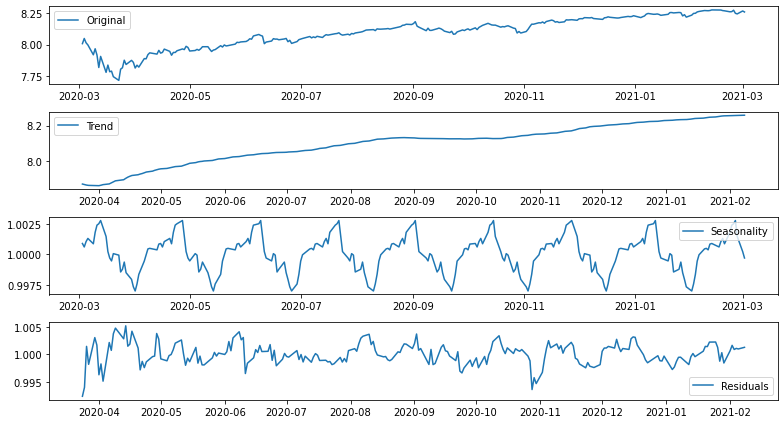

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(snp_log, model='multiplicative', period=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(snp_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- 시계열을 분해했으니, Residual에 대한 안정성을 확인합니다.

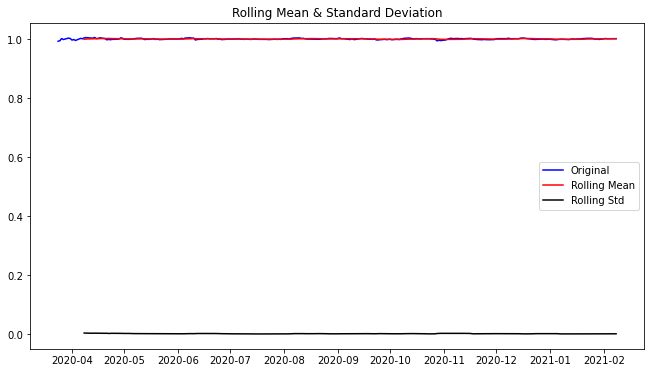

In [31]:
plot_rolling_statistics(residual)

In [32]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.590128
p-value                          0.000001
#Lags Used                      10.000000
Number of Observations Used    211.000000
Critical Value (1%)             -3.461727
Critical Value (5%)             -2.875337
Critical Value (10%)            -2.574124
dtype: float64


**residual에 대한 p-value가 낮은 것을 확인했습니다.**

- residual만 사용하면 위의 전처리를 하지 않아도 될 것 같습니다.

## 04. 학습, 테스트 데이터셋 생성
- 9:1 비율로 데이터를 나누어 줍니다.

<function matplotlib.pyplot.legend(*args, **kwargs)>

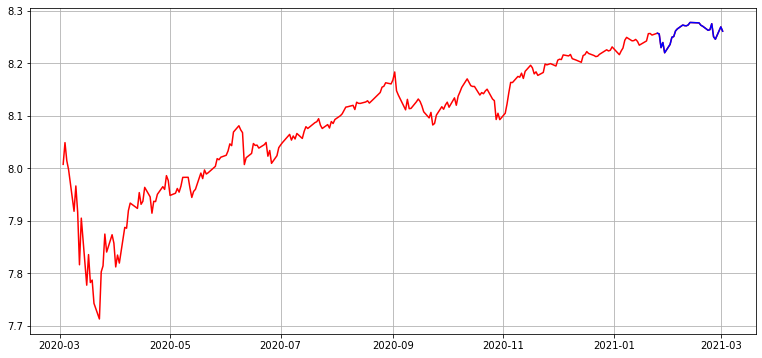

In [90]:
train, test = snp_log[:int(len(snp_log)*0.9)], snp_log[int(len(snp_log)*0.9):]

plt.figure(figsize=(13,6))
plt.grid(True)
plt.plot(snp_log, c='r', label='training dataset')
plt.plot(test, c='b', label='test dataset')
plt.legend

## 05. 적정 ARIMA 모수 찾기
- ARIMA 모델의 모수 3가지
    1. p : 자기회귀 모형(AR)의 시차
    2. d : 차분 횟수
    3. q : 이동평균 모형(MA)의 시차   
    
    
- 시계열 데이터는 자기회귀 모형(AR) 혹은 이동평균 모형(MA) 중 하나의 경향만을 강하게 띠는 특징이 있습니다.
    - 때문에 p나 q 중 하나의 값은 0입니다.
    - p+q <2, p\*q=0   
    
    
- p, q를 구하기 위해 ACF, PACF를 그려봅니다.

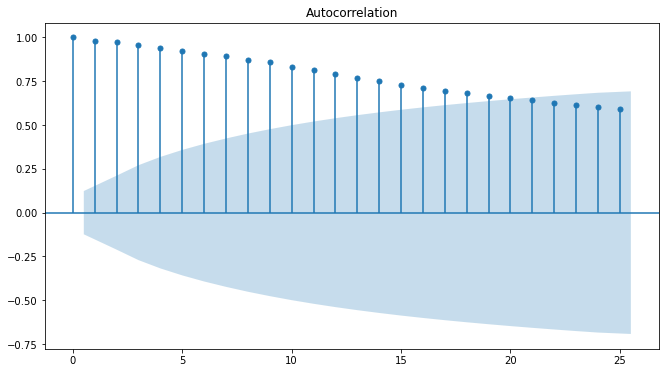

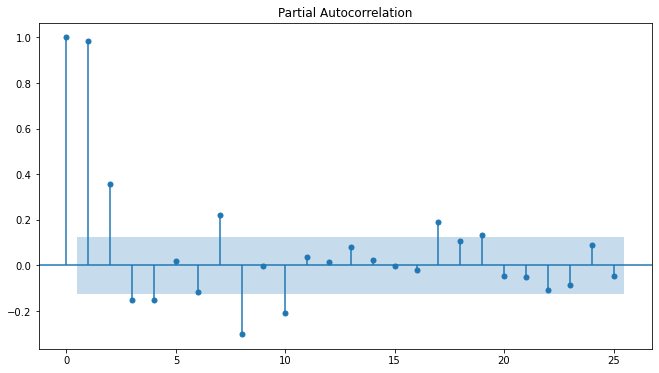

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(snp_log)
plot_pacf(snp_log)
plt.show()

### ARIMA 모델 결정하기 (MA or AR)
- 위 그래프를 보면 해당 데이터에는 AR모델이 적정하다는 것을 알 수 있습니다.
    - ACF가 점차적으로 감소하고, PACF가 특정 시점이후에 확 감소하기 때문입니다. 
        - MA모델은 반대의 형태입니다.   
        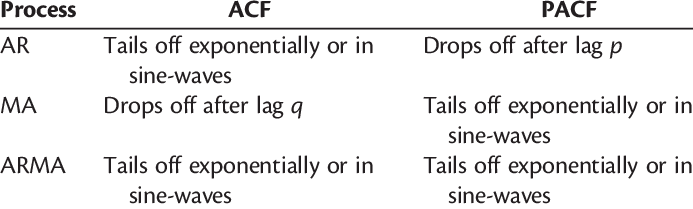
        [image source](https://www.researchgate.net/figure/The-ACF-and-PACF-patterns-relative-to-the-type-of-process_tbl1_242557410)    
        
        
- PACF는 lag(x축) 3 이후로 확 감소합니다. (dying down형태) 
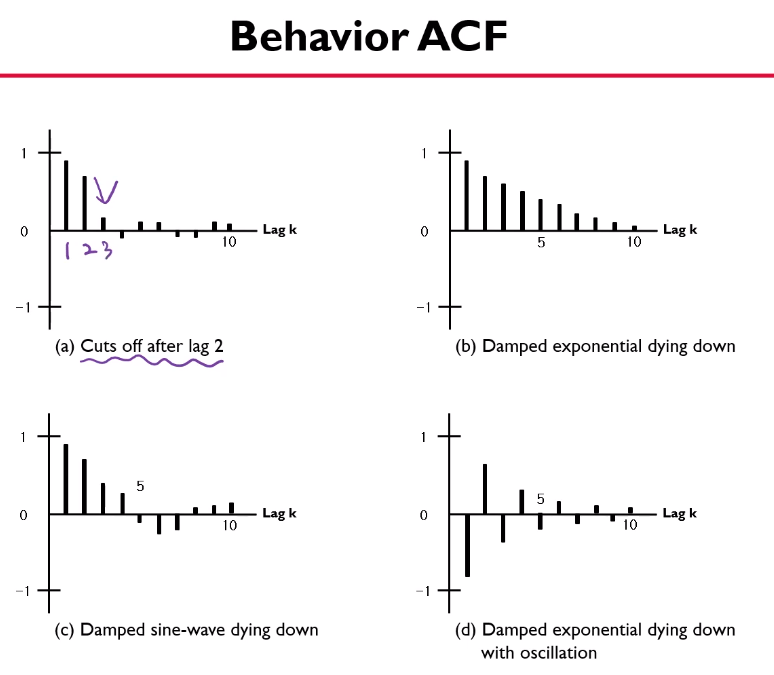
image source : [ARIMA 모델 개요 - Part 2](https://www.youtube.com/watch?v=P_3808Xv76Q&t=635s)   

### 모수 정하기 (p, d, q)
1. AR모델이기 때문에, q=0이 됩니다. 
2. p는 (절단점 -1)로 구합니다. 
    - 절단점 = lag 4 -> p = 4-1 = 3
3. d는 차분 횟수입니다. 


- d를 구하기 위해 차분 안정성을 확인합니다.

Results of Dickey-Fuller Test:
Test Statistic                -6.118723e+00
p-value                        8.962610e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.410000e+02
Critical Value (1%)           -3.457779e+00
Critical Value (5%)           -2.873609e+00
Critical Value (10%)          -2.573202e+00
dtype: float64


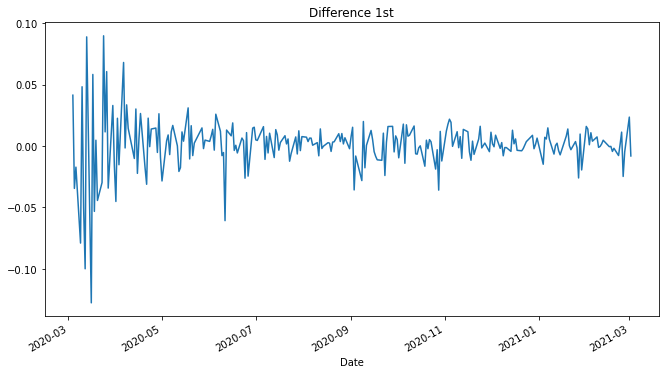

In [36]:
diff_1 = snp_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

- 차분 이후의 ACF, PACF를 확인합니다.

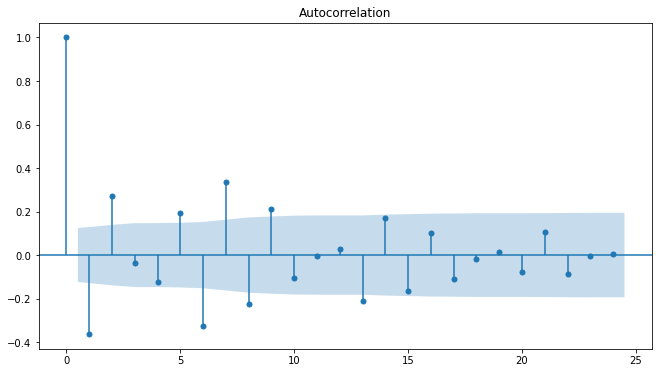

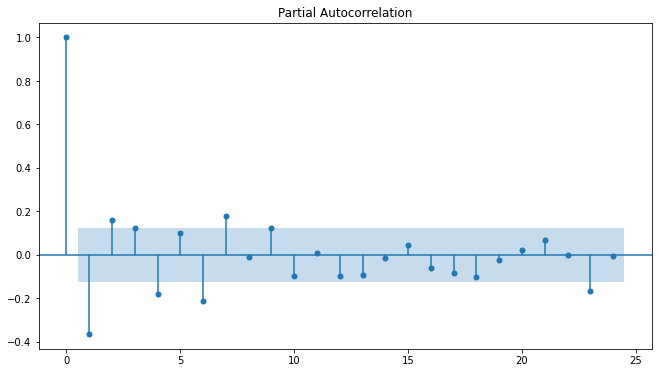

In [40]:
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

**1차 차분 후 안정성을 보이는 것으로 여겨져 1차 차분까지만 진행하겠습니다.(d=1)**

## 06. ARIMA 모델 훈련과 테스트
- 모델을 생성, 학습합니다. (p,d,q)=(3,1,0)

In [41]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train, order=(3,1,0))
fitted_m = model.fit(disp=-1)

fitted_m.summary()

/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(3, 1, 0)   Log Likelihood                 557.847
Method:                       css-mle   S.D. of innovations              0.020
Date:                Thu, 04 Mar 2021   AIC                          -1105.693
Time:                        20:57:01   BIC                          -1088.613
Sample:                             1   HQIC                         -1098.800
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0010      0.001      0.758      0.449      -0.002       0.004
ar.L1.D.Close    -0.3309      0.066     -4.993      0.000      -0.461      -0.201
ar.L2.D.Close     0.2143      0.068      3.131      0.002       0.080       0.348
ar.L3.D.Close     0.1312      0.067      1.964      0.049       0.000       0.262
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8761           -0.0000j            1.8761           -0.0000
AR.2           -1.7545           -0.9918j            2.0154           -0.4181
AR.3           -1.7545           +0.9918j            2.0154            0.4181
-----------------------------------------------------------------------------
"""

- 학습된 모델로 예측을 한 후, 결과를 시각화합니다.

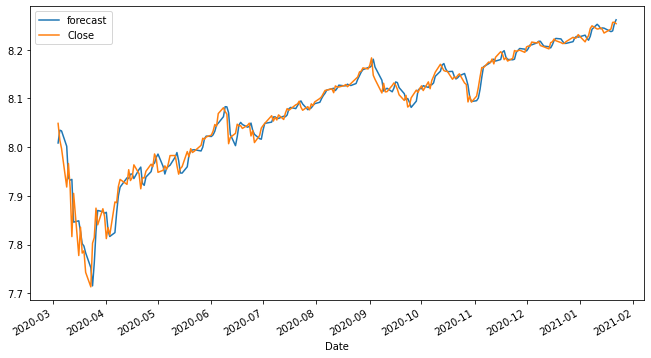

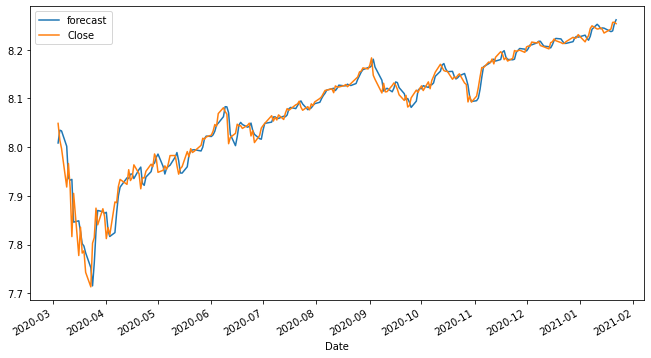

In [42]:
fitted_m.plot_predict()

- 테스트 데이터를 예측, 시각화합니다.

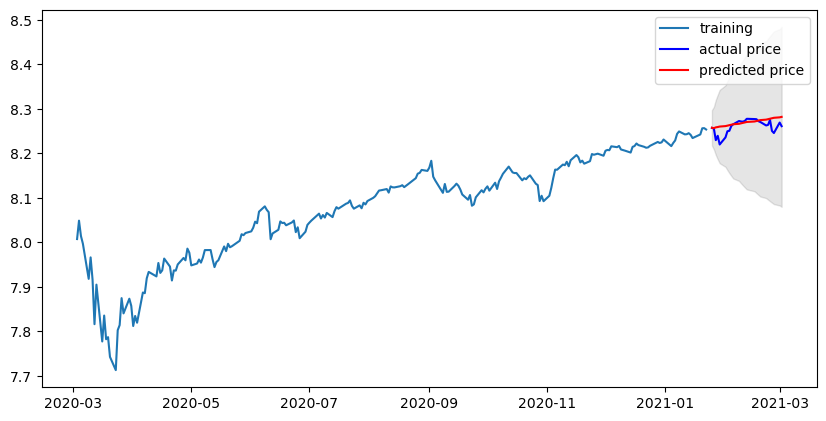

In [43]:
fc, se, conf = fitted_m.forecast(len(test), alpha=0.05)  


fc_series = pd.Series(fc, index=test.index)   
lower_series = pd.Series(conf[:, 0], index=test.index)  
upper_series = pd.Series(conf[:, 1], index=test.index)  


plt.figure(figsize=(10,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test))/np.abs(np.exp(test)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3917.1663727248965
MAE:  45.430897085902714
RMSE:  62.587270053301545
MAPE: 1.19%


**결과가 만족스럽지 않습니다. 모수를 바꿔 진행하겠습니다.**
- (3,1,0) -> (2,1,0)

In [45]:
model_2 = ARIMA(train, order=(2,1,0))
fitted_m = model_2.fit(disp=-1)

fitted_m.summary()

/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 555.935
Method:                       css-mle   S.D. of innovations              0.020
Date:                Thu, 04 Mar 2021   AIC                          -1103.870
Time:                        20:58:47   BIC                          -1090.206
Sample:                             1   HQIC                         -1098.355
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0011      0.001      0.873      0.383      -0.001       0.003
ar.L1.D.Close    -0.3066      0.066     -4.668      0.000      -0.435      -0.178
ar.L2.D.Close     0.1745      0.066      2.645      0.008       0.045       0.304
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.6715           +0.0000j            1.6715            0.5000
AR.2            3.4284           +0.0000j            3.4284            0.0000
-----------------------------------------------------------------------------
"""

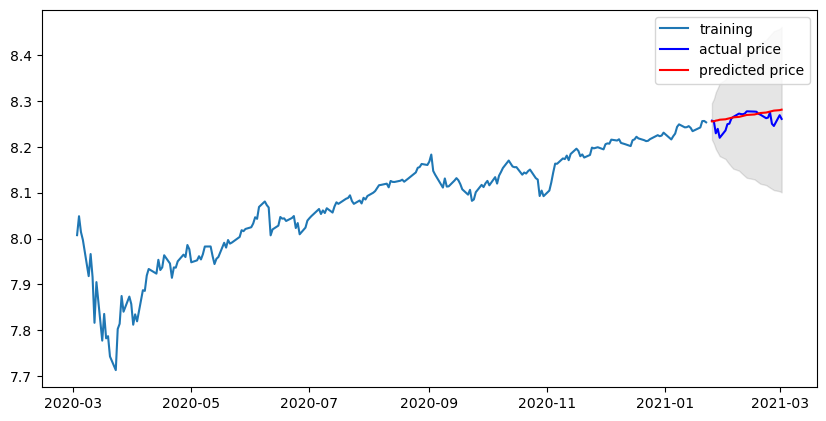

In [46]:
fc, se, conf = fitted_m.forecast(len(test), alpha=0.05)  


fc_series = pd.Series(fc, index=test.index)   
lower_series = pd.Series(conf[:, 0], index=test.index)  
upper_series = pd.Series(conf[:, 1], index=test.index)  


plt.figure(figsize=(10,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test))/np.abs(np.exp(test)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3693.568434075817
MAE:  44.476082333976365
RMSE:  60.774735162531286
MAPE: 1.16%


**p=2, d=1, q=0일 때 가장 낮은 MAPE를 달성할 수 있었습니다.**

## 07. 다른 주식 종목도 예측해보겠습니다.
1) Dow Jones 지수를 예측해보겠습니다.

In [117]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/^DJI.csv'
df = pd.read_csv(dataset_filepath, index_col=['Date'], parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-04,26383.679688,27102.339844,26286.310547,27090.859375,27090.859375,4575900
2020-03-05,26671.919922,26671.919922,25943.330078,26121.279297,26121.279297,4773700
2020-03-06,25457.210938,25994.380859,25226.619141,25864.779297,25864.779297,5997800
2020-03-09,24992.359375,24992.359375,23706.070313,23851.019531,23851.019531,7504300
2020-03-10,24453.000000,25020.990234,23690.339844,25018.160156,25018.160156,6548600


In [118]:
ts_dow = df['Close']
print(type(ts_dow))
ts_dow.head()

<class 'pandas.core.series.Series'>


Date
2020-03-04    27090.859375
2020-03-05    26121.279297
2020-03-06    25864.779297
2020-03-09    23851.019531
2020-03-10    25018.160156
Name: Close, dtype: float64

In [120]:
ts_dow[ts_dow.isna()][:10]
ts_dow.isnull().sum()

0

In [122]:
ts_dow.interpolate(method='time')
ts_dow[ts_dow.isna()]

Series([], Name: Close, dtype: float64)

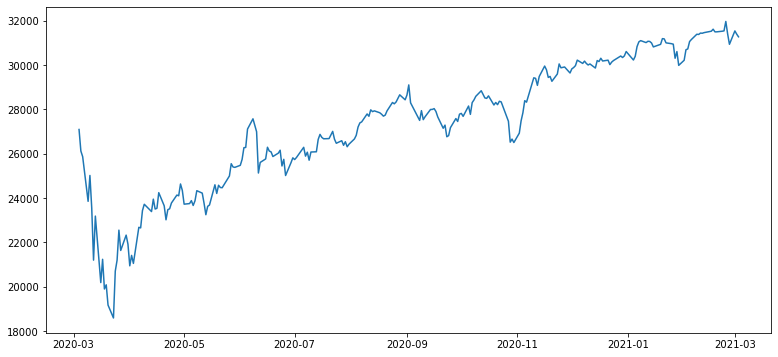

In [123]:
rcParams['figure.figsize']=13, 6

plt.plot(ts_dow)

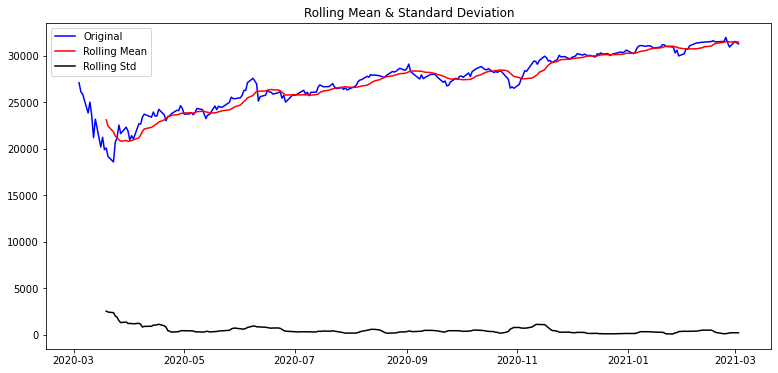

In [124]:
plot_rolling_statistics(ts_dow, window=12)

In [125]:
augmented_dickey_fuller_test(ts_dow)

Results of Dickey-Fuller Test:
Test Statistic                  -1.904523
p-value                          0.329936
#Lags Used                      10.000000
Number of Observations Used    241.000000
Critical Value (1%)             -3.457779
Critical Value (5%)             -2.873609
Critical Value (10%)            -2.573202
dtype: float64


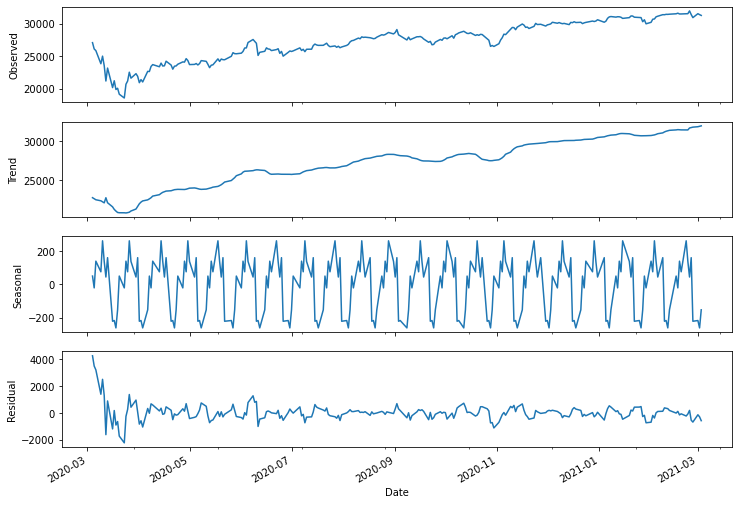

In [126]:
result = seasonal_decompose(df['Close'], model='addictive', two_sided=True, \
                           period=12, extrapolate_trend='freq')

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,9))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

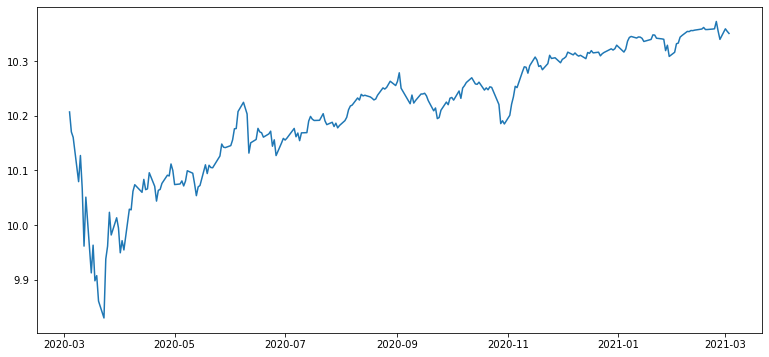

In [127]:
dow_log = np.log(ts_dow)
plt.plot(dow_log)

In [128]:
augmented_dickey_fuller_test(dow_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.231584
p-value                          0.194983
#Lags Used                      10.000000
Number of Observations Used    241.000000
Critical Value (1%)             -3.457779
Critical Value (5%)             -2.873609
Critical Value (10%)            -2.573202
dtype: float64


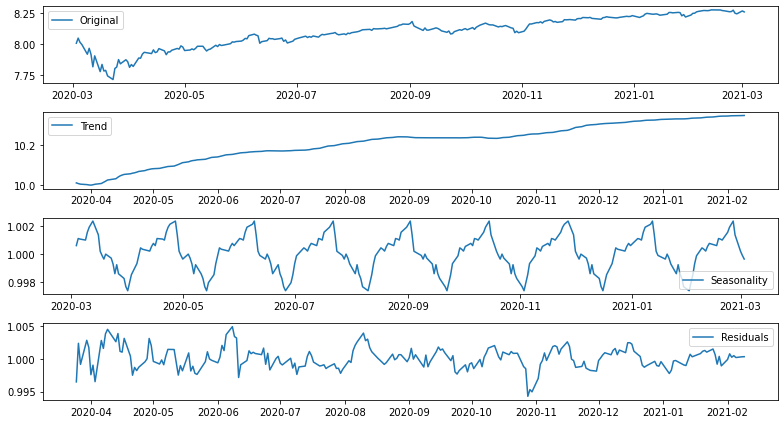

In [139]:
decomposition = seasonal_decompose(dow_log, model='multiplicative', period=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(snp_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

<function matplotlib.pyplot.legend(*args, **kwargs)>

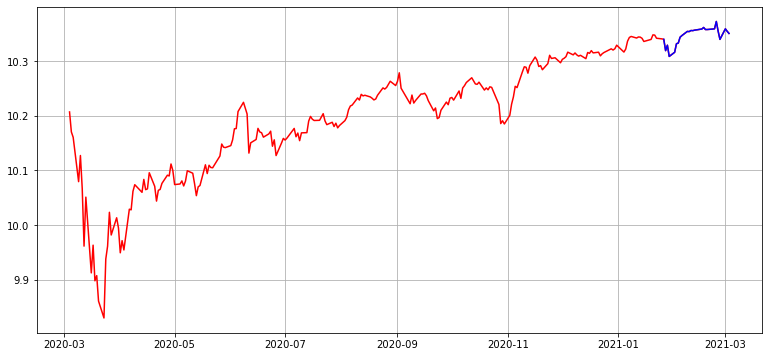

In [142]:
train, test = dow_log[:int(len(dow_log)*0.9)], dow_log[int(len(dow_log)*0.9):]

plt.figure(figsize=(13,6))
plt.grid(True)
plt.plot(dow_log, c='r', label='training dataset')
plt.plot(test, c='b', label='test dataset')
plt.legend

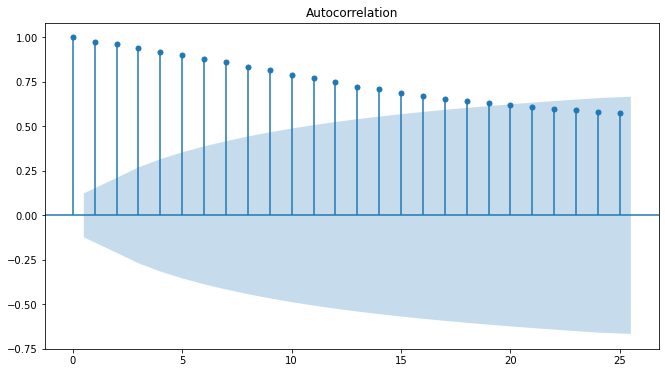

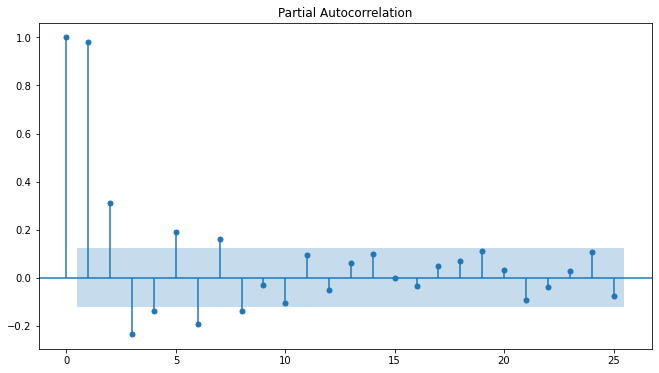

In [143]:
plot_acf(dow_log)
plot_pacf(dow_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -6.835665e+00
p-value                        1.845354e-09
#Lags Used                     9.000000e+00
Number of Observations Used    2.410000e+02
Critical Value (1%)           -3.457779e+00
Critical Value (5%)           -2.873609e+00
Critical Value (10%)          -2.573202e+00
dtype: float64


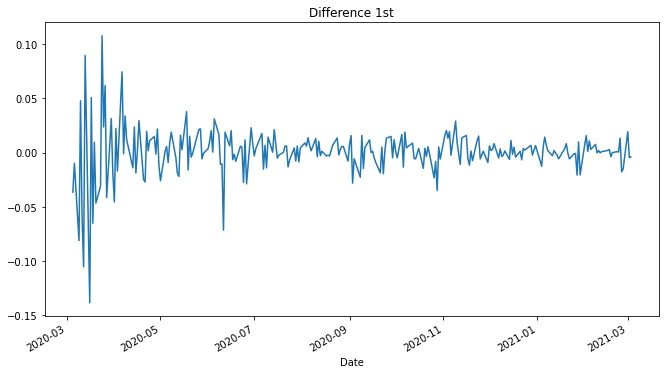

In [144]:
diff_1 = dow_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [145]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train, order=(2,1,0))
fitted_m = model.fit(disp=-1)

fitted_m.summary()

/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 540.418
Method:                       css-mle   S.D. of innovations              0.022
Date:                Thu, 04 Mar 2021   AIC                          -1072.837
Time:                        23:17:58   BIC                          -1059.172
Sample:                             1   HQIC                         -1067.322
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0006      0.001      0.414      0.679      -0.002       0.003
ar.L1.D.Close    -0.2481      0.065     -3.795      0.000      -0.376      -0.120
ar.L2.D.Close     0.2135      0.065      3.269      0.001       0.086       0.342
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.6597           +0.0000j            1.6597            0.5000
AR.2            2.8215           +0.0000j            2.8215            0.0000
-----------------------------------------------------------------------------
"""

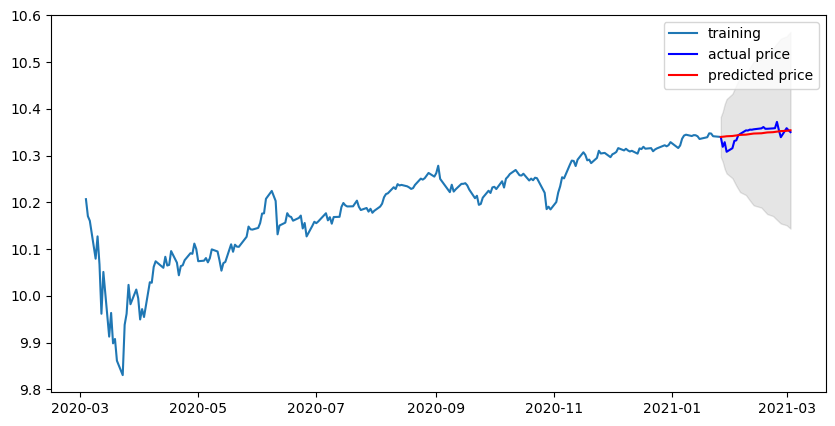

In [146]:
fc, se, conf = fitted_m.forecast(len(test), alpha=0.05)  


fc_series = pd.Series(fc, index=test.index)   
lower_series = pd.Series(conf[:, 0], index=test.index)  
upper_series = pd.Series(conf[:, 1], index=test.index)  


plt.figure(figsize=(10,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [147]:
mse = mean_squared_error(np.exp(test), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test))/np.abs(np.exp(test)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  155337.72659575896
MAE:  315.69623253296345
RMSE:  394.12907352256946
MAPE: 1.02%


**Dow Jones지수도 MAPE 1.02%로 잘 예측되었습니다.**

2) NASDAQ 지수를 예측해보겠습니다.

In [164]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/NQ=F.csv'
df = pd.read_csv(dataset_filepath, index_col=['Date'], parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-04,8557.5,8950.00,8508.25,8896.50,8896.50,939032.0
2020-03-05,8889.0,8899.75,8610.75,8648.75,8648.75,954104.0
2020-03-06,8677.0,8726.50,8310.50,8503.25,8503.25,1097279.0
2020-03-08,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-09,8369.0,8375.00,7820.00,7951.50,7951.50,560913.0


In [165]:
ts_nq = df['Close']
print(type(ts_nq))
ts_nq.head()

<class 'pandas.core.series.Series'>


Date
2020-03-04    8896.50
2020-03-05    8648.75
2020-03-06    8503.25
2020-03-08        NaN
2020-03-09    7951.50
Name: Close, dtype: float64

In [166]:
ts_nq[ts_nq.isna()][:10]
ts_nq.isnull().sum()

54

In [167]:
ts_nq=ts_nq.interpolate(method='time')
ts_nq[ts_nq.isna()]

Series([], Name: Close, dtype: float64)

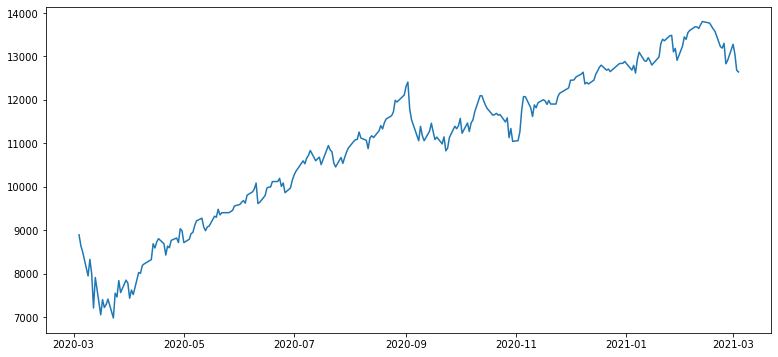

In [168]:
rcParams['figure.figsize']=13, 6

plt.plot(ts_nq)

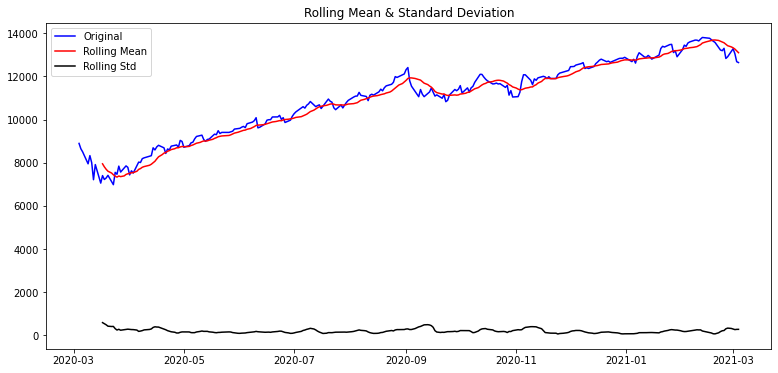

In [169]:
plot_rolling_statistics(ts_nq, window=12)

In [170]:
augmented_dickey_fuller_test(ts_nq)

Results of Dickey-Fuller Test:
Test Statistic                  -2.144902
p-value                          0.226847
#Lags Used                      12.000000
Number of Observations Used    292.000000
Critical Value (1%)             -3.452945
Critical Value (5%)             -2.871490
Critical Value (10%)            -2.572071
dtype: float64


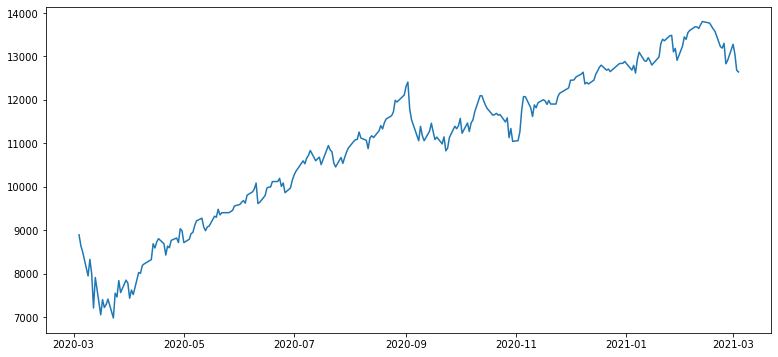

In [180]:
nq_log = np.log(ts_nq)
plt.plot(ts_nq)

In [181]:
augmented_dickey_fuller_test(nq_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.727871
p-value                          0.069338
#Lags Used                      12.000000
Number of Observations Used    292.000000
Critical Value (1%)             -3.452945
Critical Value (5%)             -2.871490
Critical Value (10%)            -2.572071
dtype: float64


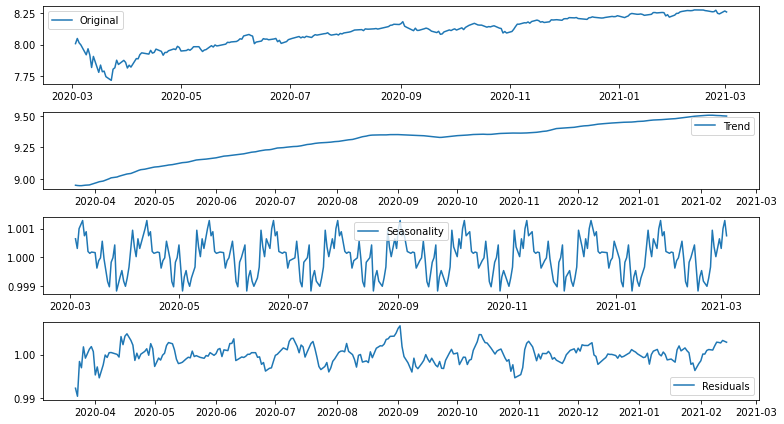

In [182]:
decomposition = seasonal_decompose(nq_log, model='multiplicative', period=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(snp_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

<function matplotlib.pyplot.legend(*args, **kwargs)>

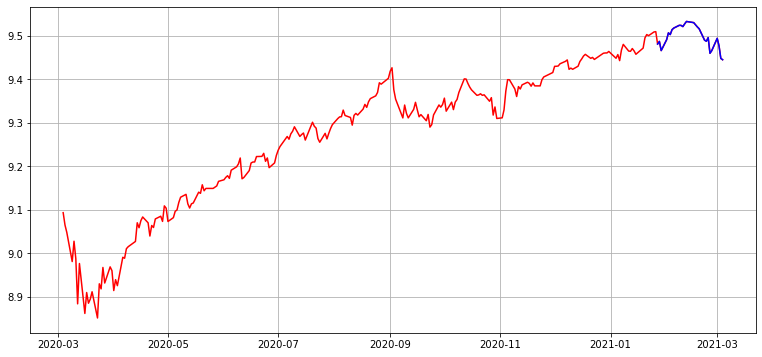

In [183]:
train, test = nq_log[:int(len(nq_log)*0.9)], nq_log[int(len(nq_log)*0.9):]

plt.figure(figsize=(13,6))
plt.grid(True)
plt.plot(nq_log, c='r', label='training dataset')
plt.plot(test, c='b', label='test dataset')
plt.legend

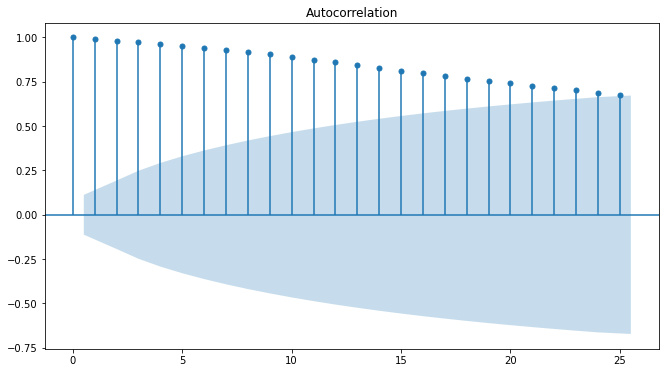

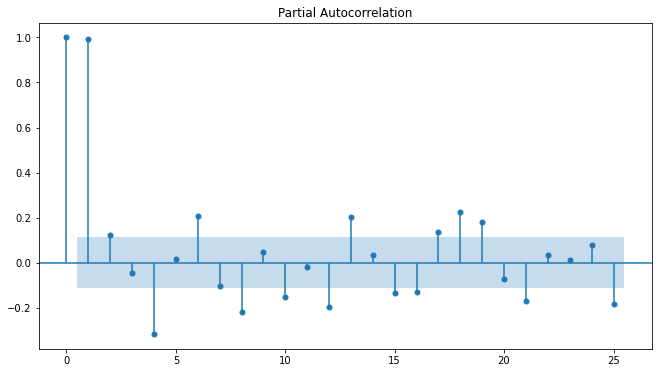

In [184]:
plot_acf(nq_log)
plot_pacf(nq_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -5.890817e+00
p-value                        2.927419e-07
#Lags Used                     1.100000e+01
Number of Observations Used    2.920000e+02
Critical Value (1%)           -3.452945e+00
Critical Value (5%)           -2.871490e+00
Critical Value (10%)          -2.572071e+00
dtype: float64


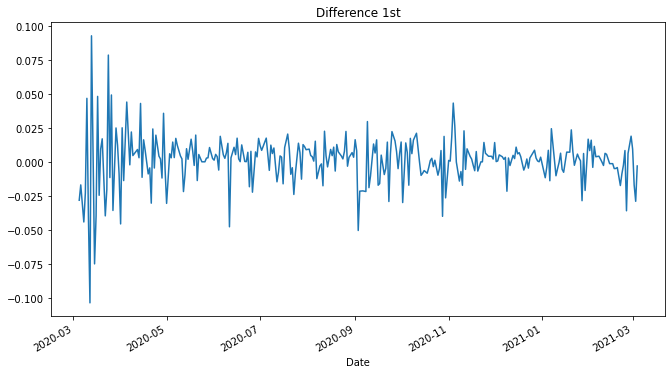

In [193]:
diff_1 = nq_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [194]:
model = ARIMA(train, order=(2,1,0))
fitted_m = model.fit(disp=-1)

fitted_m.summary()

/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                  273
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 702.462
Method:                       css-mle   S.D. of innovations              0.018
Date:                Thu, 04 Mar 2021   AIC                          -1396.924
Time:                        23:35:05   BIC                          -1382.486
Sample:                             1   HQIC                         -1391.128
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0016      0.001      1.812      0.070      -0.000       0.003
ar.L1.D.Close    -0.2308      0.061     -3.806      0.000      -0.350      -0.112
ar.L2.D.Close    -0.0738      0.061     -1.218      0.223      -0.193       0.045
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5635           -3.3324j            3.6810           -0.3198
AR.2           -1.5635           +3.3324j            3.6810            0.3198
-----------------------------------------------------------------------------
"""

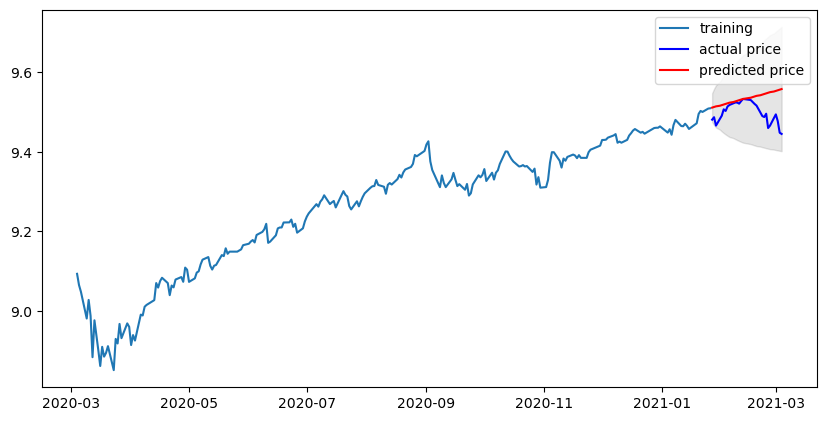

In [195]:
fc, se, conf = fitted_m.forecast(len(test), alpha=0.05)  


fc_series = pd.Series(fc, index=test.index)   
lower_series = pd.Series(conf[:, 0], index=test.index)  
upper_series = pd.Series(conf[:, 1], index=test.index)  


plt.figure(figsize=(10,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [196]:
mse = mean_squared_error(np.exp(test), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test))/np.abs(np.exp(test)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  419444.4061555513
MAE:  478.37464311181066
RMSE:  647.6452780307684
MAPE: 3.66%


**위의 두 데이터에 비해는 높은 점수지만(육안으로 보기에도 잘 예측하지 못한 것 같다.) 10% 이하를 달성했다.**

# 루브릭 평가
---
1. **시계열의 안정성이 충분히 확인되었는가?**   

    - 시계열 분해를 이용하고, adfuller 모듈을 이용해서 p-value를 확인하며 안정성을 확인하는 과정을 거쳤다.


2. **ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?**

    - p, d, q의 의미와 모델을 선택하는 방법에 대해 찾아보고 정리하였다.
     
     
3. **예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?** 

    - 나스닥, 다우존스, 금값 모두 MAPE 10% 이하로 오차율이 적었다.
    
    
# 회고
---
## 어려웠던 점 
- ARIMA 모형, 모수
    - 노드에는 모델에 대한 (특히 모델 모수를 선택하는 방법) 설명이 상세하지 않아서 여러 자료를 참고했다. 
    - 다행히 팀원분들이 자료를 주셔서 참고하며 정리할 수 있었다. 
    - 하지만 다른 블로그 실습 글 등에서도 모수를 계속 바꿔가면서 최적의 값을 찾아야한다고 해서 결국 이것도 실험을 계속 거쳐야하는 건가 싶었다.
    
## 알게된 점 
- ACF, PACF를 분석해 모델을 결정하고 모수를 조정하는 방법
    
## 더 공부할 점
- ARIMA 모형의 원리
    - 수식을 이해하면 더 깊게 이해할 수 있을 것이다.
- 시계열 분해(decomposition)과 ARIMA 모형 모수의 관계성 
    - 분해를 다 하고, 결국 모형의 모수는 ACF, PACF만을 갖고 조정했기 때문에 이 점이 궁금하다.
- 로그변환
    - 로그변환과 분산의 관계

## 다짐
- 저번에 살짝 공부했던 시계열 분석방법에 대해 더 깊게 알 수 있었던 계기가 되었다. 궁금한 점을 하나하나 검색하다보니 계획했던 것보다 많은 시간을 들이게 되었지만, 확실하게 머릿속에 정리해두게 된 계기가 되었다. 또 여러 모델을 분석하고 사용하기 위해서는 기초적인 수학지식이 필요하다는 것을 느꼈다. 다음주부터 하게 될 확률통계스터디가 탄탄한 배경지식으로 바뀌길 기대한다.